## Coupling forest dynamics (NetLogo) with hillslope sediment transport (Landlab)
This notebook shows how a simple forest dynamics model can be coupled to Landlab components using PyNetLogo. The forest dynamics model is an Agent Based Model (ABM) developed in NetLogo. The example shows how to link this ABM with the LinearDiffuser component in Landlab 2.0. If you have the standard packages installed with the Anaconda distribution of Python 3, you will only need to check for the following additional items:<br>

1. NetLogo is installed (versions 5.2, 5.3, or 6.0 ONLY)
2. 'tree_soil_pro_simple.nlogo' is in the local directory
3. Seaborn library for data visualization is installed (https://seaborn.pydata.org/)
4. OPTIONAL: 'xy_trees_initial.xlsx' is in the local directory

_last modified by mwrossi on 05.31.2020_

In [1]:
# Import packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import LinearDiffuser
import pyNetLogo

%matplotlib inline

In [2]:
# Open NetLogo
# Running the headless version of NetLogo will dramatically speed up computation
netlogo = pyNetLogo.NetLogoLink(gui=False)

In [3]:
# Check version of NetLogo
# The most recent version of NetLogo (v6.1) is not supported by PyNetLogo
# Make sure your installed version is 5.2, 5.3, or 6.0
print(netlogo.netlogo_version)

6.0


## Model description
This is a reduced complexity version of a model for soil production by tree root growth currently being developed by Matthew Rossi, Greg Tucker, Suzanne Anderson, and Bob Anderson. Variables that have been removed for the sake of demonstration are indicated by strikethrough text. This notebook is structured into three main parts:<br>

1. Running a headless version of NetLogo in Python
2. Reading variables from NetLogo to Landlab and then writing them back to NetLogo
3. Running a coupled NetLogo - Landlab model
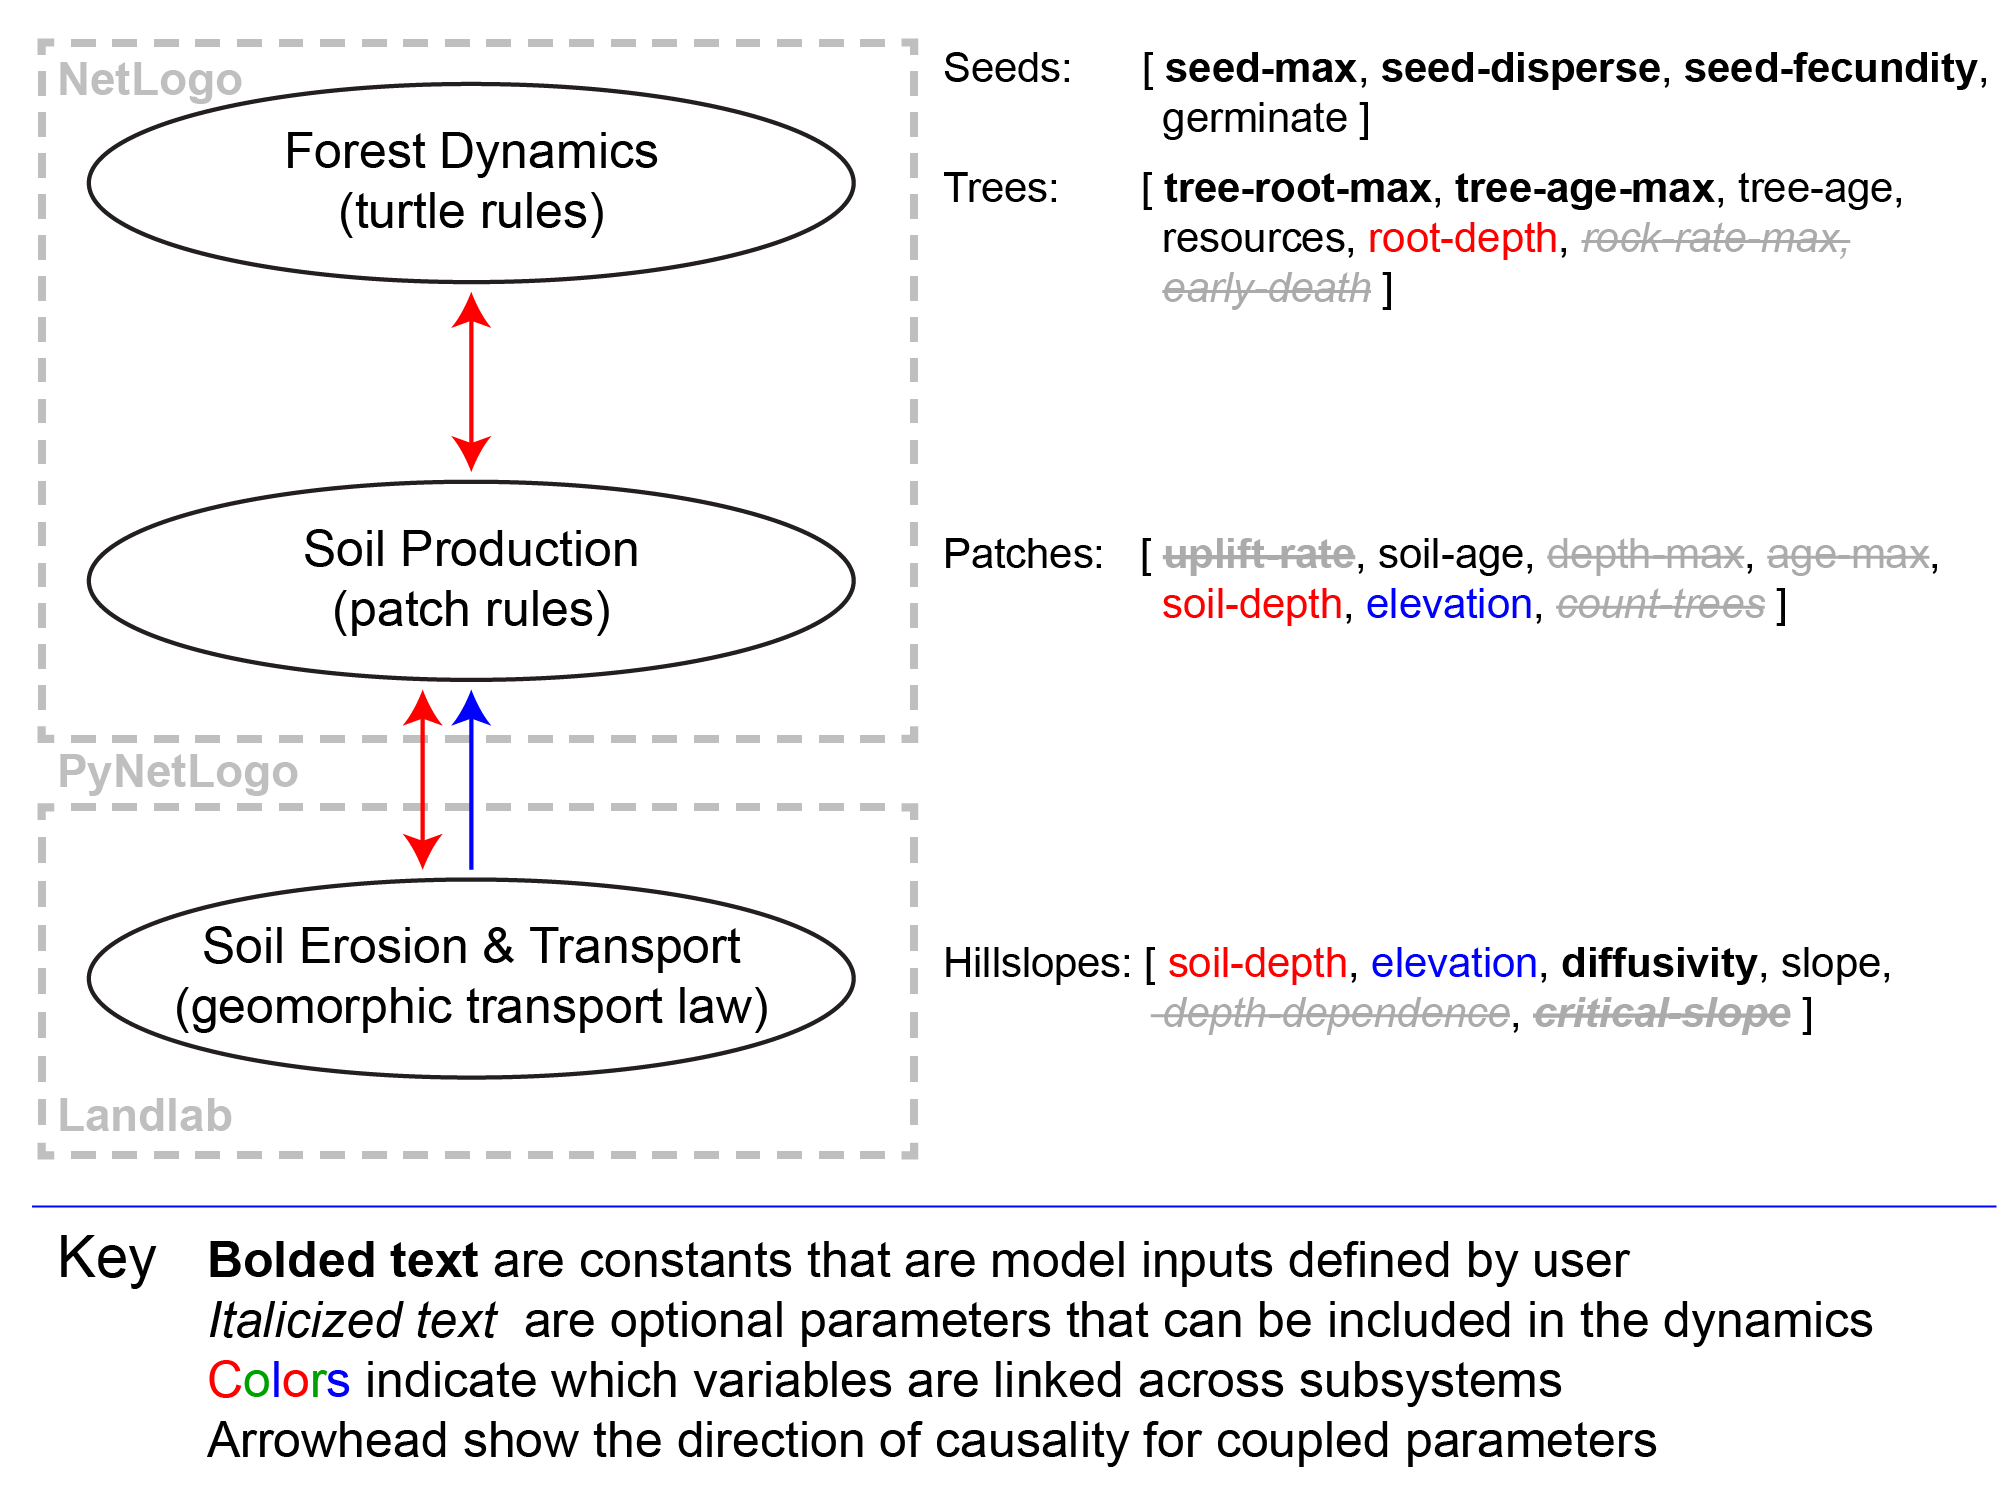

## 1 Running NetLogo from Python using pyNetLogo

For documentation and tutorials see:<br>
https://pynetlogo.readthedocs.io/en/latest/

In [4]:
# Open NetLogo, load model, and setup initial conditions
netlogo.load_model('./tree_soil_pro_simple.nlogo')
netlogo.command('set initial-number-trees 5')  # [1 to 20]
netlogo.command('set tree-root-max 3.0')       # [0.1 to 3.0]
netlogo.command('set tree-age-max 100')        # [1 to 200]
netlogo.command('set seed-max 5')             # [1 to 30]
netlogo.command('set seed-disperse 8')        # [1 to 40]
netlogo.command('set seed-fecundity 0.975')    # [0.975 to 0.999]
netlogo.command('setup')

In [58]:
# OPTIONAL CELL
# Use this if you want to specify the coordinates of the initial locations of trees
# MAKE SURE initial-number-trees (n) is the same as occur in excel sheet
# Otherwise, it will only modify the positions of the first n agents
# Read in excel file with agent xy coordinates
agent_xy = pd.read_excel('./xy_trees_initial.xlsx')
netlogo.write_NetLogo_attriblist(agent_xy[['who','xcor','ycor']], 'tree')
agent_xy[['who','xcor','ycor']].head()

,who,xcor,ycor
0,0,18,18
1,1,18,56
2,2,56,18
3,3,56,56


## 1.1 Map out the initial condition
Whether you used the random seed in NetLogo or specified your own inital population of trees, we will now plot them out in space. Recall, that we are using toroidal boundary conditions such that trees that lie near the edge of the spatial domain still contribute to the population dynamics. The associated distribution of soil depths is also mapped out at the same scale. For the initial condition, this should simply be a grid of zeros.

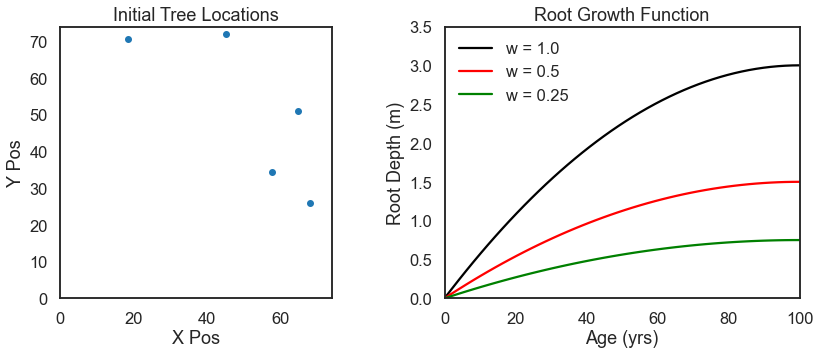

In [5]:
# Report initial location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')

# Root growth function for input parameters (w=1)
life = netlogo.report('tree-age-max')
coef1 = netlogo.report('tree-growth-a')
coef2 = netlogo.report('tree-growth-b')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show map of tree locations
ax1.scatter(x, y, s=30)
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Initial Tree Locations')

# Show optimum root growth trajectory
x = np.linspace(0.0, float(life), endpoint=True)
ax2.plot(x, (coef1 * (x**2)) + (coef2 * x), '-k', label='w = 1.0');
ax2.plot(x, 0.5 * ((coef1 * (x**2)) + (coef2 * x)), '-r', label='w = 0.5');
ax2.plot(x, 0.25 * ((coef1 * (x**2)) + (coef2 * x)), '-g', label='w = 0.25');
ax2.set(xlim=(0, life), ylim=(0, 3.5), xlabel='Age (yrs)', ylabel='Root Depth (m)', title='Root Growth Function')
ax2.legend(loc='upper left', frameon=False)

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

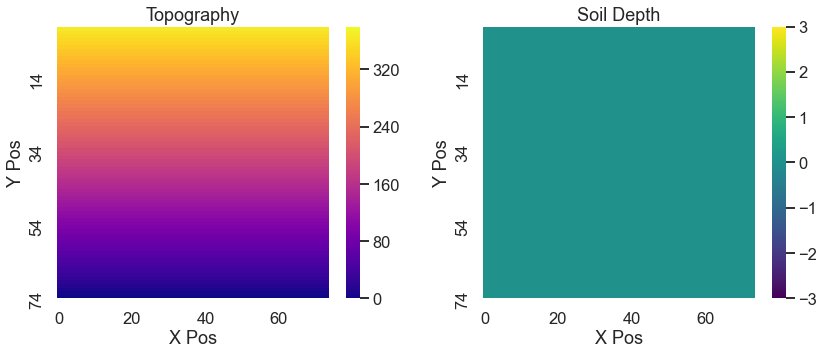

In [6]:
# Report initial topography (constant slope towards bottom)
topo = netlogo.patch_report('elevation')

# Report initial depths of soil (should be 0 everywhere initially)
sdepths = netlogo.patch_report('soil-depth')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show map of topography
patches = sns.heatmap(topo, vmin=0., vmax=380., xticklabels=20, yticklabels=20, ax=ax1, cmap='plasma')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')

# Show map of soil depths
patches = sns.heatmap(sdepths, vmin=-3., vmax=3., xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

## 1.2 Run the model
We will now run the model for 500 ticks (which are meant to represent years) to examine how the spatial patterns of trees and soil evolve. How long this takes to run will depend on how many agents are produced for a given configuration of input parameters (for 500 ticks, less than a minute). Nevertheless, in my experience, this headless version of NetLogo runs a couple of orders of magnitude faster than operating within the gui, though I have not formally tested it.

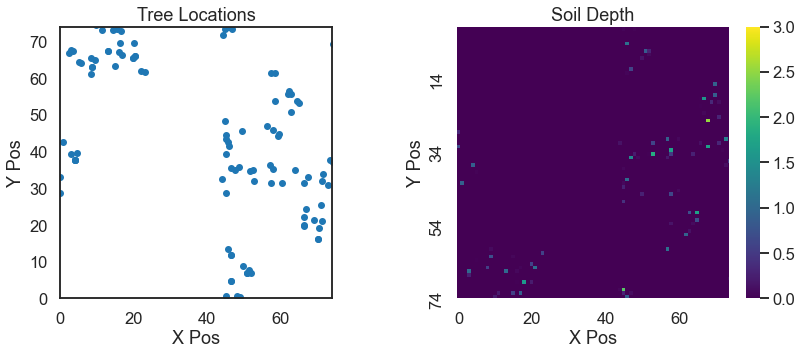

In [7]:
# Run the model forward 100 ticks
netlogo.command('repeat 100 [go]')

# Report the current location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')

# Report initial depths of soil (should be 0 everywhere initially)
sdepths = netlogo.patch_report('soil-depth')

# Show current maps
fig, (ax1, ax2) = plt.subplots(1, 2)

# Tree locations
ax1.scatter(x, y, s=30)
ax1.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Tree Locations')

# Soil depths
patches = sns.heatmap(sdepths, vmin=0, vmax=3.0, xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

# Note that if you just keep running this cell, that you are starting from the previous model state.

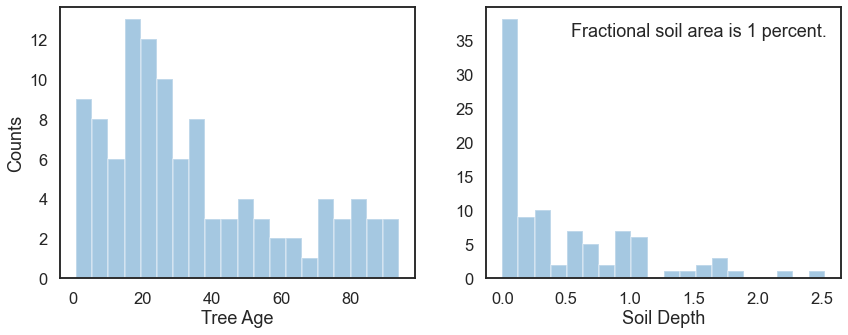

In [8]:
# Examine the tree age and soil depth distributions
# Report agen attributes from NetLogo
tree_ages = netlogo.report('[tree-age] of trees')
soil_depths = netlogo.report('[soil-depth] of patches with [pcolor = yellow]')
soil_frac = netlogo.report('100 * count soil / (76 * 76)')#' patches with [pcolor != yellow]')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show distribution of tree ages
sns.distplot(tree_ages, kde=False, bins=20, ax=ax1, label='Tree Ages')
ax1.set_xlabel('Tree Age')
ax1.set_ylabel('Counts')

# Show distribution of soil depths
sns.distplot(soil_depths, kde=False, bins=20, ax=ax2, label='Soil Depths')
ax2.set_xlabel('Soil Depth')
result = 'Fractional soil area is %d percent.' % soil_frac
ax2.annotate(result, xy=(0.5,0.5), xytext=(0.24,0.89), textcoords='axes fraction', fontsize=18)

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

## 2 Coupling the model with Landlab
Let's re-start the model with an eye towards passing the values for soil depth and elevation between NetLogo and Landlab. For now let's allow the forest dynamics to evolve over some timescale, pass the topography and soil grids to landlab, diffuse the landscape, and pass these results back to NetLogo.<br>

We will use the [LinearDiffuser](https://landlab.readthedocs.io/en/master/reference/components/diffusion.html) component in Landlab based on Culling (1963). We can use this same approach to test the sensitivity of results to different hillslope transport laws (e.g., depth-dependent diffusion, nonlinear diffusion), but for now we will take adavantage of the simplicity of using this one. Despite its simplicity, we will still have to treat the diffusion constant as spatially variable (i.e., one value for soil and another for bedrock)<br>

### References
Culling, W. (1963). Soil Creep and the Development of Hillside Slopes. The Journal of Geology 71(2), 127-161. https://dx.doi.org/10.1086/626891

In [9]:
# Re-initialize the NetLogo model using same configuration as above
netlogo.command('setup')
  
# Setup landlab grid with boundary and initial conditions
tt = 1000
dx = 5.
mg = RasterModelGrid((75, 75), xy_spacing = dx)
mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_FIXED_VALUE,
                               top=mg.BC_NODE_IS_FIXED_VALUE,
                               left=mg.BC_NODE_IS_FIXED_VALUE,
                               bottom=mg.BC_NODE_IS_FIXED_VALUE)

In [10]:
# Add fields to landlab grid
z = mg.add_zeros('topographic__elevation', at='node')
zp = mg.add_zeros('past__elevation', at='node')
c = mg.add_zeros('soil__cover', at='node')
d = mg.add_zeros('soil__depth', at='node')

## 2.1 Run NetLogo and send values to Landlab
We will now run NetLogo and bring the 'elevation' and 'soil-depth' data (Pandas dataframes) into a format that can be used by Landlab models grids.<br>

In [11]:
# Run the model forward in NetLogo:
go = 'repeat %d [go]' % (tt)
netlogo.command(go)

# Report elevation and pass to landlab
topo = netlogo.patch_report('elevation')
topo = topo.to_numpy()
zpass = np.reshape(topo, (5625))
z[:] = zp[:] = zpass

# Report soil depth and pass to landlab
sdepths = netlogo.patch_report('soil-depth')
sdepths = sdepths.to_numpy()
sdpass = np.reshape(sdepths, (5625))
d[:] = sdpass

# Set soil cover field based on soil depths [this is actually our diffusivity constant field]
c[:] = np.digitize(3.0-d,bins=[3.0])
c[:] = c[:] * 0.99999 + 0.00001       # transform cover into diffusivities

# print average soil depth to compare values post-diffusion
print(np.mean(d[:]))

# Note that we are allowing bedrock to diffuse at a rate 10,000 times slower than the soil-mantled surfaces
# This means that soil is effectively being created (albeit slowly) when we diffuse the landscape

0.168388729777


In [12]:
# Initialize diffusion component
diffuse = LinearDiffuser(mg, linear_diffusivity='soil__cover', method='simple', deposit=True)

# Diffuse landscape and calculate soil depth
diffuse.run_one_step(tt)
d[:] += z[:] - zp[:]
zp[:] = z[:]

# This is all a bit of a hack right now, because there is no soil depth limitation to diffusion.
# Need to update 'method' to help with conservation of soil issues 

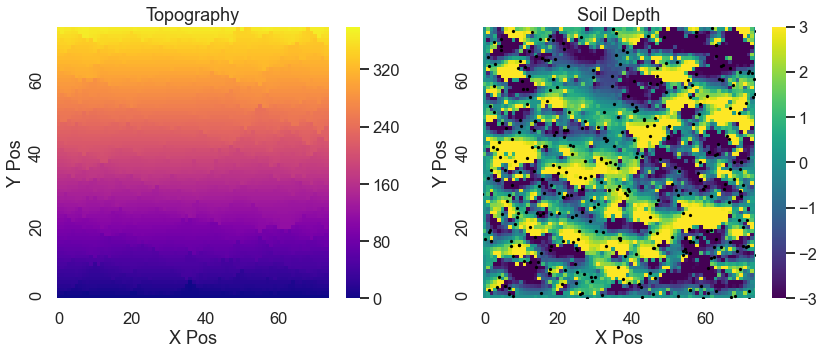

-0.0498269723153


In [13]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot topography
grid = np.reshape(z, (75,75))
patches = sns.heatmap(grid, vmin=0, vmax=380, xticklabels=20, yticklabels=20, ax=ax1, cmap='plasma')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')

# Plot soil depths
grid = np.reshape(d, (75,75))
patches = sns.heatmap(grid, vmin=-3.0, vmax=3.0, xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Report the current location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')
ax2.scatter(x, y, s=3, c='k')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

# Compare this value to the one to above to see 'extra' soil being produced by not modeling soil and bedrock explicitly
print(np.mean(d[:]))

## 2.2 Send Landlab results back to NetLogo
Now that we have diffused the landscape, let's send the results back to NetLogo to run the forest dynamics models and see what happens. 

In [14]:
# Reformat new elevation data to send back to NetLogo
zpass = np.reshape(z, (75,75))
df = pd.DataFrame(data=zpass)
netlogo.patch_set('elevation', df)

# Reformat new soil-depth data to send back to NetLogo
dpass = np.reshape(d, (75,75))
df = pd.DataFrame(data=dpass)
netlogo.patch_set('soil-depth', df)

# Run NetLogo again
netlogo.command(go)

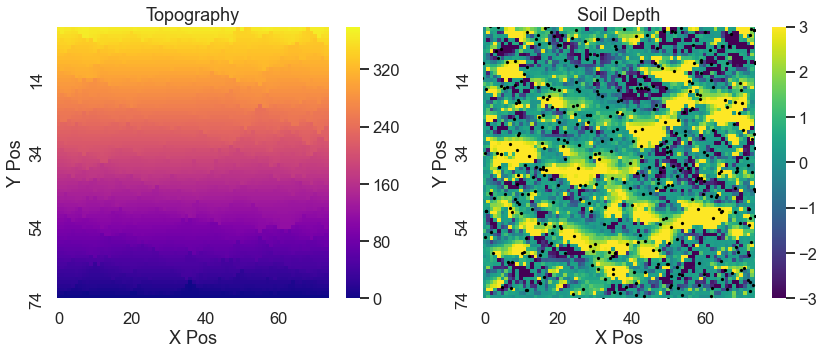

In [15]:
# Let's plot it up to see how things changed
# Report the current location of trees and soil depths
xt = netlogo.report('map [s -> [xcor] of s] sort trees')
yt = netlogo.report('map [s -> [ycor] of s] sort trees')
topo = netlogo.patch_report('elevation')
sdepths = netlogo.patch_report('soil-depth')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot topography
patches = sns.heatmap(topo, vmin=0, vmax=380, xticklabels=20, yticklabels=20, ax=ax1, cmap='plasma')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')
#ax1.invert_yaxis()

# Plot soil depths
patches = sns.heatmap(sdepths, vmin=-3., vmax=3., xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')
#ax2.invert_yaxis()

# Report the current location of trees
ax2.scatter(xt, yt, s=3, c='k')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

# Note the topography should not have changed, because this version our NetLogo model is only modifying soil depth

## 3 Running the coupled model

The time step for running the diffusion model was large with respect to changes in the forest structure. So, for this version we are going to combine all the steps above, but iterate through shorter time steps to pass data between the two models.

In [16]:
#Inputs
tt = 1000     # total time
dt = 100      # Landlab time step
dx = 5.       # grid scale

# Re-initialize the NetLogo model using same configuration as above
netlogo.command('setup')
  
# Setup landlab grid with GTL boundary and initial conditions
mg = RasterModelGrid((75, 75), xy_spacing = dx)
mg.set_status_at_node_on_edges(right=mg.BC_NODE_IS_FIXED_VALUE,
                               top=mg.BC_NODE_IS_FIXED_VALUE,
                               left=mg.BC_NODE_IS_FIXED_VALUE,
                               bottom=mg.BC_NODE_IS_FIXED_VALUE)
# Add fields to landlab grid
z = mg.add_zeros('topographic__elevation', at='node')
zp = mg.add_zeros('past__elevation', at='node')
c = mg.add_zeros('soil__cover', at='node')
d = mg.add_zeros('soil__depth', at='node')

In [17]:
# for loop that includes each of the steps above
# This will take a bit longer than before (up to a few minutes)
nt = int(tt // dt)

for i in range(tt):
    # Run the model forward in NetLogo:
    go = 'repeat %d [go]' % (dt)
    netlogo.command(go)
    
    # Report elevation and pass to landlab
    topo = netlogo.patch_report('elevation')
    topo = topo.to_numpy()
    zpass = np.reshape(topo, (5625))
    z[:] = zp[:] = zpass
    
    # Report soil depth and pass to landlab
    sdepths = netlogo.patch_report('soil-depth')
    sdepths = sdepths.to_numpy()
    sdpass = np.reshape(sdepths, (5625))
    d[:] = sdpass
    
    # Set soil cover field based on soil depths
    c[:] = np.digitize(3.0-d,bins=[3.0])
    c[:] = c[:] * 0.99999 + 0.00001
    
    # Initialize diffusion component
    diffuse = LinearDiffuser(mg, linear_diffusivity='soil__cover', method='simple', deposit=True)
    
    # Diffuse the landscape
    diffuse.run_one_step(dt)
    d[:] += z[:] - zp[:]
    zp[:] = z[:]
    
    # Reformat new elevation data to send back to NetLogo
    zpass = np.reshape(z, (75,75))
    df = pd.DataFrame(data=zpass)
    netlogo.patch_set('elevation', df)
    
    # Reformat new soil-depth data to send back to NetLogo
    dpass = np.reshape(d, (75,75))
    df = pd.DataFrame(data=dpass)
    netlogo.patch_set('soil-depth', df)
    
    # Run NetLogo again
    netlogo.command(go)

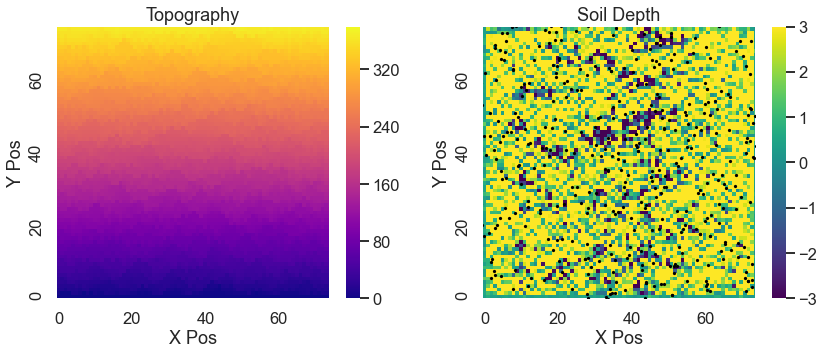

3.74936481603


In [18]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot topography
grid = np.reshape(z, (75,75))
patches = sns.heatmap(grid, vmin=0, vmax=380, xticklabels=20, yticklabels=20, ax=ax1, cmap='plasma')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')

# Plot soil depths
grid = np.reshape(d, (75,75))
patches = sns.heatmap(grid, vmin=-3.0, vmax=3.0, xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Report the current location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')
ax2.scatter(x, y, s=3, c='k')
#ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Tree Locations')


# Size and show plots
fig.set_size_inches(14,5)
plt.show()

print(np.mean(d[:]))

In [97]:
# Good idea to kill the workspace after you are done
netlogo.kill_workspace()